Load the training data.

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt


(train_x, train_y), (test_x, test_y) = utils.processed_data()

Train the deep neuro-fuzzy classifier on Fashion MNIST.

Using TensorFlow backend.
W0312 11:20:28.685187 140623394182976 deprecation.py:506] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0312 11:20:28.730741 140623394182976 deprecation.py:506] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0848 - categorical_accuracy: 0.8248 - val_loss: 0.0656 - val_categorical_accuracy: 0.8704
Epoch 2/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0607 - categorical_accuracy: 0.8762 - val_loss: 0.0580 - val_categorical_accuracy: 0.8822
Epoch 3/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0552 - categorical_accuracy: 0.8874 - val_loss: 0.0533 - val_categorical_accuracy: 0.8958
Epoch 4/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.0514 - categorical_accuracy: 0.8948 - val_loss: 0.0518 - val_categorical_accuracy: 0.8930
Epoch 5/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0483 - categorical_accuracy: 0.9032 - val_loss: 0.0490 - val_categorical_accuracy: 0.9002
Epoch 6/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.0469 - categor

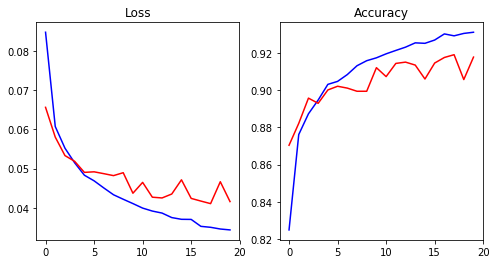

In [2]:
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K
from model import LogGaussMF


def train_hybrid():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, (3, 3), strides=(1,1), padding="same", name="conv1"),
        layers.BatchNormalization(scale=False),
        layers.Activation("relu"),
        layers.Dropout(rate=0.2),
        layers.Conv2D(32, (3, 3), strides=(2,2), padding="same", name="conv2"),
        layers.BatchNormalization(scale=False),
        layers.Activation("relu"),
        layers.Dropout(rate=0.2),
        layers.Conv2D(64, (3, 3), strides=(2,2), padding="same", name="conv3"),
        layers.BatchNormalization(scale=False),
        layers.Activation("relu"),
        layers.Dropout(rate=0.2),
        layers.Flatten(),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0005),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=256,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")

    return model


model = train_hybrid()

Below are plots of the activations for each convolutional layer.

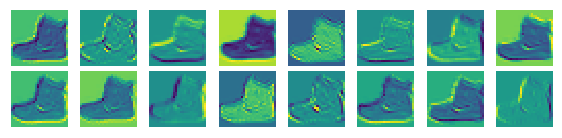

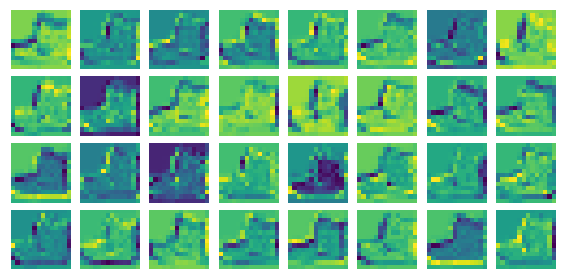

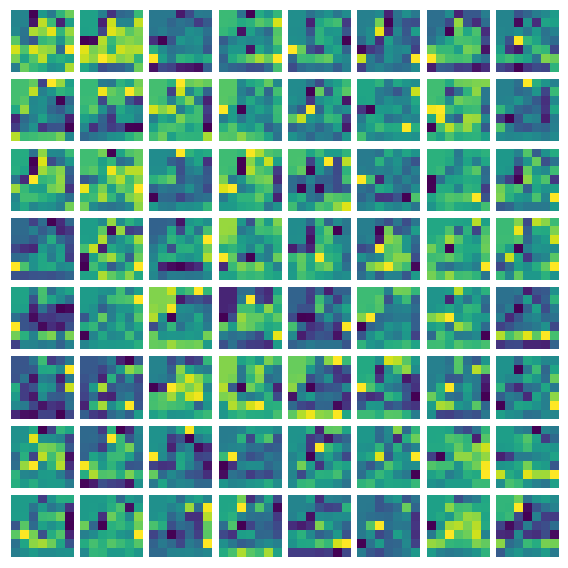

In [3]:
import keras.backend as K


image = train_x[0].reshape(1,28,28)

conv1_fn = K.function(model.inputs, [model.get_layer("conv1").output])
conv2_fn = K.function(model.inputs, [model.get_layer("conv2").output])
conv3_fn = K.function(model.inputs, [model.get_layer("conv3").output])


conv1_features = conv1_fn([image])[0]
fig, axes = plt.subplots(2, 8, figsize=(8,2))
axes = axes.flatten()
for i in range(16):
    axes[i].imshow(conv1_features[...,i].squeeze())

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)


conv2_features = conv2_fn([image])[0]
fig, axes = plt.subplots(4, 8, figsize=(8,4))
axes = axes.flatten()
for i in range(32):
    axes[i].imshow(conv2_features[...,i].squeeze())

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)


conv3_features = conv3_fn([image])[0]
fig, axes = plt.subplots(8, 8, figsize=(8,8))
axes = axes.flatten()
for i in range(64):
    axes[i].imshow(conv3_features[...,i].squeeze())

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

This is an attempt to create a model to reverse the feature extraction part of the network. It is moderately successful on reversing images as shown below.

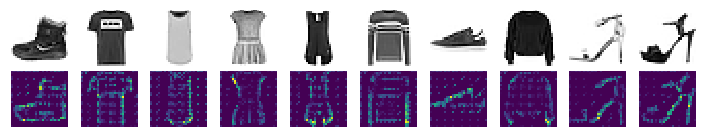

In [4]:
deconv_model = keras.Sequential([
    layers.Conv2DTranspose(
        32, 3, strides=(2, 2),
        padding='same', 
        use_bias=False, 
        name="tconv3", 
        input_shape=(7,7,64)),
    layers.Activation("relu"),
    layers.Conv2DTranspose(
        16, 3, strides=(2, 2), 
        padding='same', 
        use_bias=False, 
        name="tconv2"),
    layers.Activation("relu"),
    layers.Conv2DTranspose(
        1, 3, 
        padding='same', 
        use_bias=False, 
        name="tconv1"),
    layers.Activation("relu"),
])

k3, b3 = model.get_layer("conv3").get_weights()
k2, b2 = model.get_layer("conv2").get_weights()
k1, b1 = model.get_layer("conv1").get_weights()

deconv_model.get_layer("tconv3").set_weights([k3])
deconv_model.get_layer("tconv2").set_weights([k2])
deconv_model.get_layer("tconv1").set_weights([k1])

fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    image = train_x[i].reshape(1, 28, 28)
    conv3_features = conv3_fn([image])[0]
    deconv_image = deconv_model.predict(conv3_features - b3)
    
    axes[0][i].imshow(image.squeeze(), cmap="Greys")
    axes[1][i].imshow(deconv_image.squeeze())

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Attempting to reverse mu and beta do not yield much of use unfortunately.

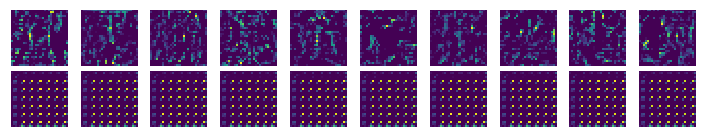

In [5]:
mu, beta = model.layers[-3].get_weights()

deconv_mu = deconv_model.predict(mu.reshape(-1, 7, 7, 64))
deconv_beta = deconv_model.predict(beta.reshape(-1, 7, 7, 64))

fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    axes[0][i].imshow(deconv_mu[i].squeeze())
    axes[1][i].imshow(deconv_beta[i].squeeze())

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

This code replicates the gradients analyzer from the innvestigate. It was intended as a stepping stone towards implementing guided backprop.

True
True
True
True
True
True
True
True
True
True


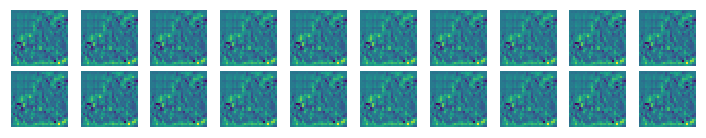

In [6]:
import tensorflow as tf
import innvestigate
from keras.models import Model
    
    
def gradient(model, input_image, neuron_index=0):
    grad = [np.zeros((10,), dtype=np.float32)]
    grad[0][neuron_index] = 1
    
    for layer in model.layers[-2:0:-1]:    
        grad = tf.gradients(
            ys=layer.output,
            xs=layer.input,
            grad_ys=grad[0],
            stop_gradients=layer.input)
        
    sess = K.get_session()
    grad_val = sess.run(
        grad, 
        feed_dict={model.input: input_image})
            
    return grad_val[0]


model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "gradient", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)

image = train_x[0].reshape(1,28,28)
    
fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    analysis = analyzer.analyze(image, i).squeeze()
    grad = gradient(model, image, neuron_index=i).squeeze()
    
    axes[0][i].imshow(analysis)
    axes[1][i].imshow(grad)
    
    print(np.allclose(analysis, grad, atol=1e-6))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

While all of the images appear the same, the average value changes. This implies changing the neuron index works as intended and innvestigate is working.

1.7979802
1.8161297
1.8286326
1.7710867
1.8017739
1.7073629
1.8130773
1.7391078
1.7746361
1.7218769


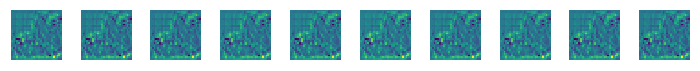

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    analysis = analyzer.analyze(train_x[0].reshape(1,28,28), i).squeeze()
    axes[i].imshow(analysis)
    print(np.mean(analysis))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

My implementation of guided back-prop compared with iNNvestigates implementation.

True
True
True
True
True
True
True
True
True
True


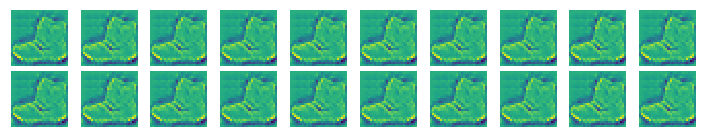

In [8]:
def guided_backprop(model, input_image, neuron_index=0):
    grad = tf.gradients(
        ys=model.layers[-2].output[:,neuron_index],
        xs=model.layers[-2].input,
        grad_ys=model.layers[-2].output[:,neuron_index],
        stop_gradients=model.layers[-2].input)
    
    for layer in model.layers[-3:0:-1]:            
        grad = tf.gradients(
            ys=layer.output,
            xs=layer.input,
            grad_ys=grad[0],
            stop_gradients=layer.input)
        
        if getattr(layer, 'activation', None) == keras.activations.get("relu"):
            grad = [tf.nn.relu(grad[0])]
        
    sess = K.get_session()
    grad_val = sess.run(
        grad, 
        feed_dict={model.input: input_image})
            
    return grad_val[0]


model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)

image = train_x[0].reshape(1,28,28)
    
fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    analysis = analyzer.analyze(image, i).squeeze()
    grad = guided_backprop(model, image, neuron_index=i).squeeze()
    
    axes[0][i].imshow(analysis)
    axes[1][i].imshow(grad)
    
    print(np.allclose(analysis, grad))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Changing the neuron index does change the result slightly as can be infered by the average changing. It may be the case that the input gradient with respect to each output are all very similar for this model.

-589.0151
-592.3197
-596.8538
-582.0221
-589.2323
-563.6
-584.9779
-560.7684
-568.7645
-546.4139


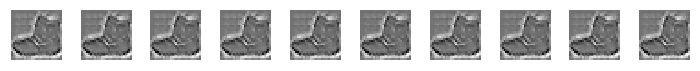

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    analysis = analyzer.analyze(train_x[0].reshape(1,28,28), i).squeeze()
    axes[i].imshow(analysis, cmap="Greys")
    print(np.mean(analysis))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The plots below show the differences between guided backpropagation for each pair of output neurons, While the differences cannot be seen in the images above, they are there. Images along the diagonal should be blank and I am not sure why some noise appears.

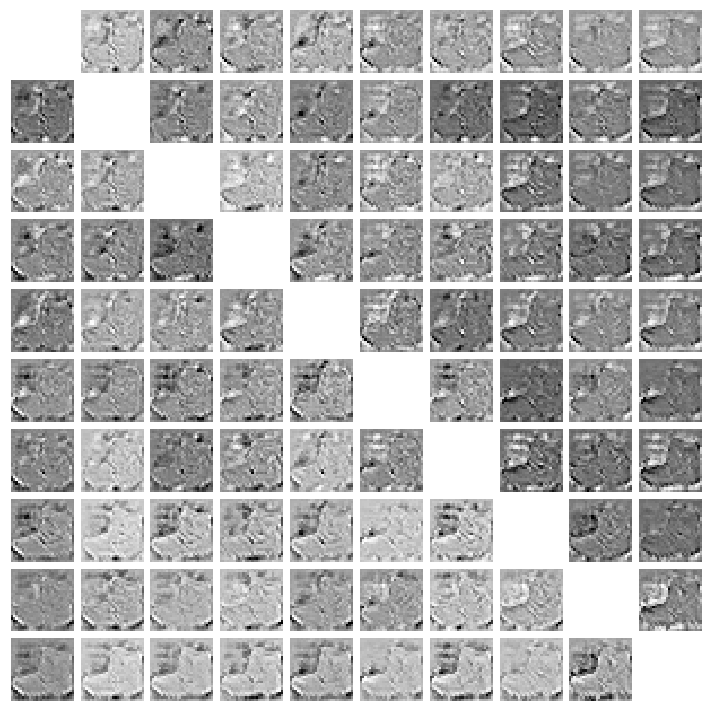

In [10]:
image = train_x[0].reshape(1,28,28)

fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):  
    for j in range(10):
        analysis1 = analyzer.analyze(image, i).squeeze()
        analysis2 = analyzer.analyze(image, j).squeeze()
        axes[i][j].imshow(analysis1 - analysis2, cmap="Greys")

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The plots below show mu and beta plotted as 10 sets of 64 7x7 images.

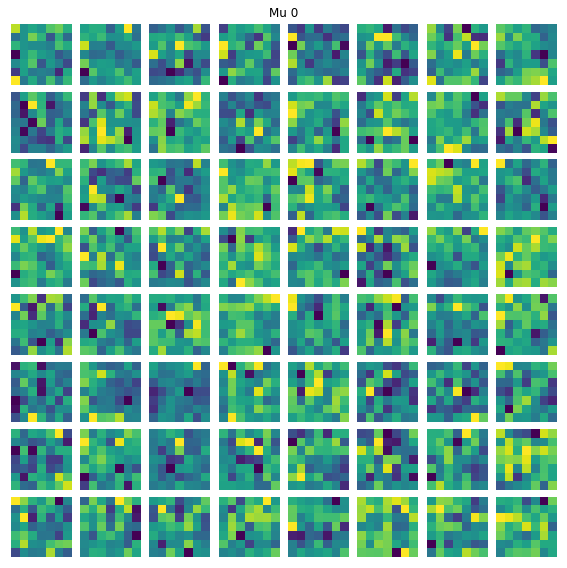

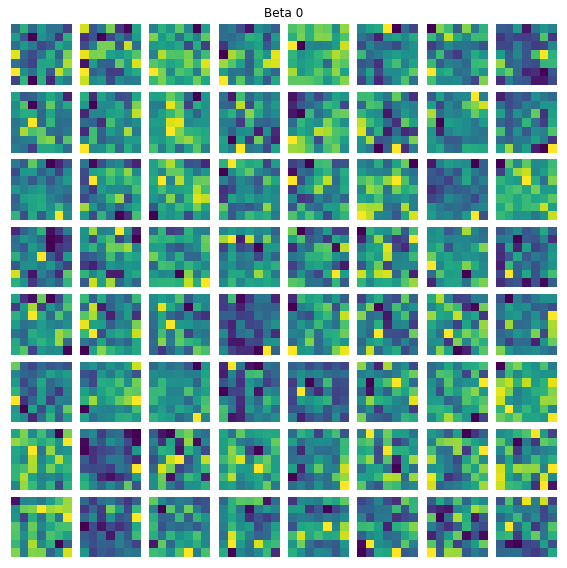

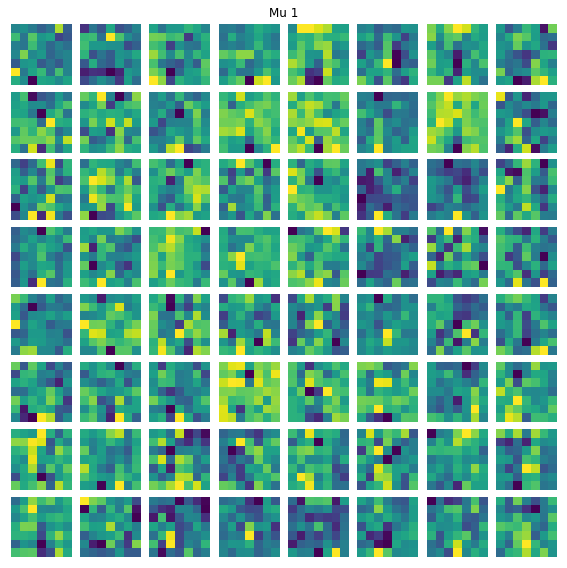

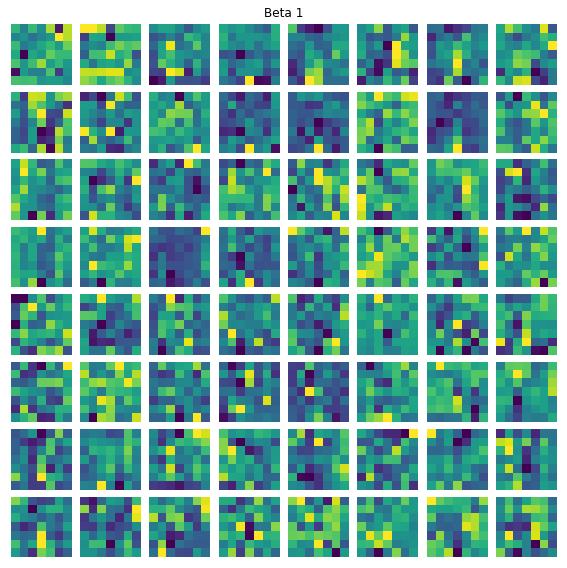

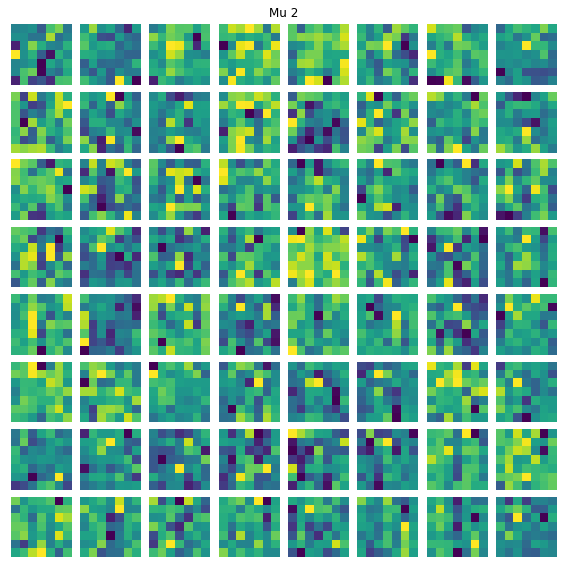

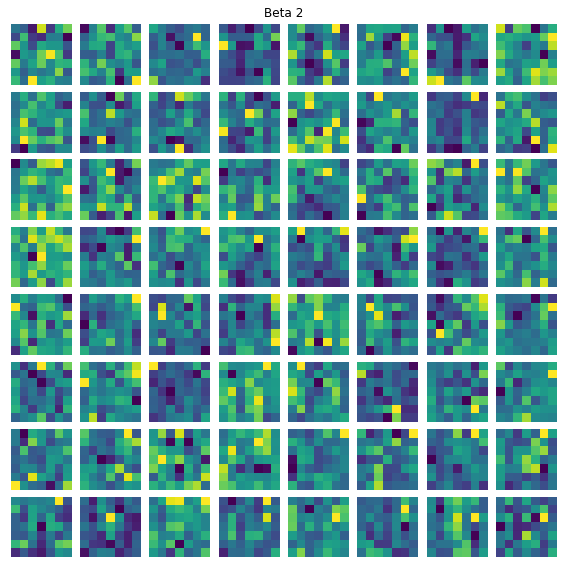

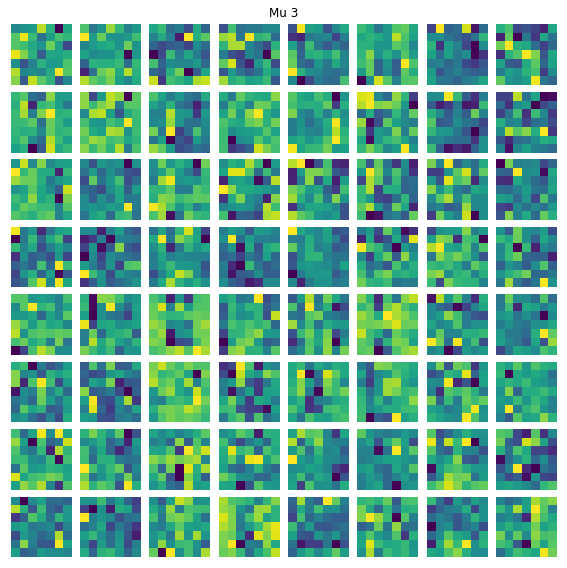

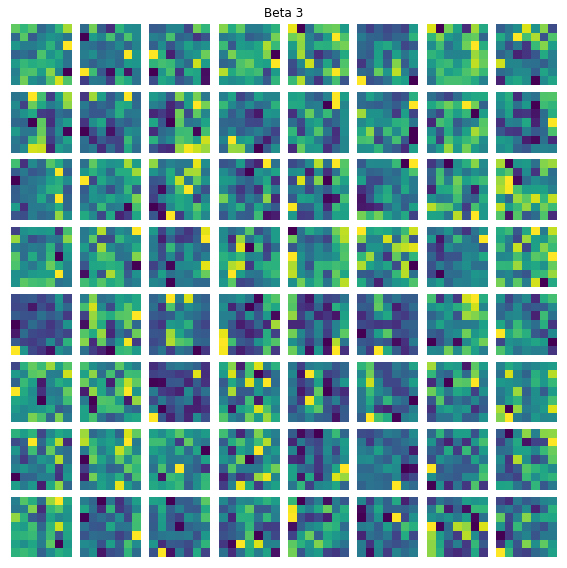

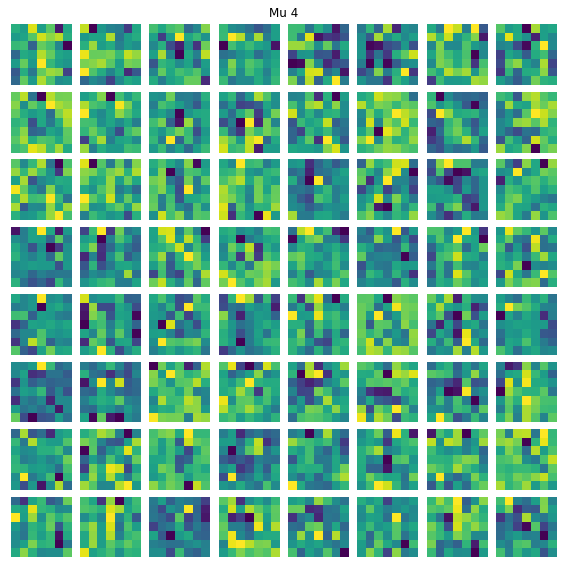

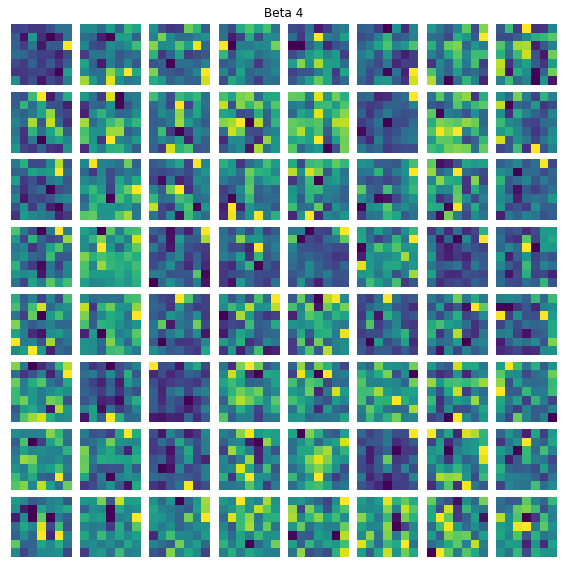

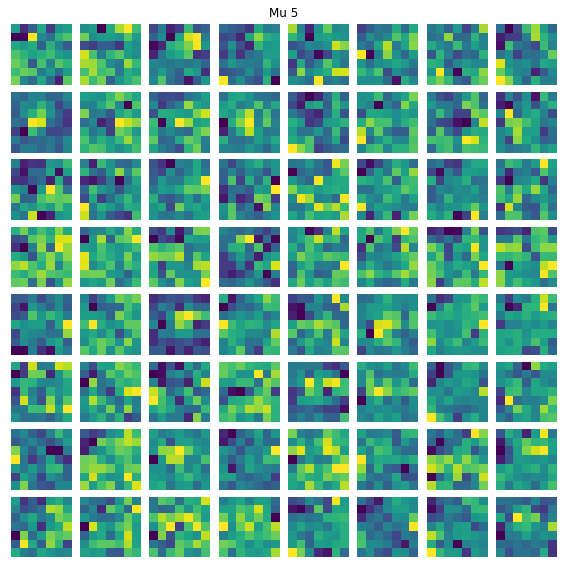

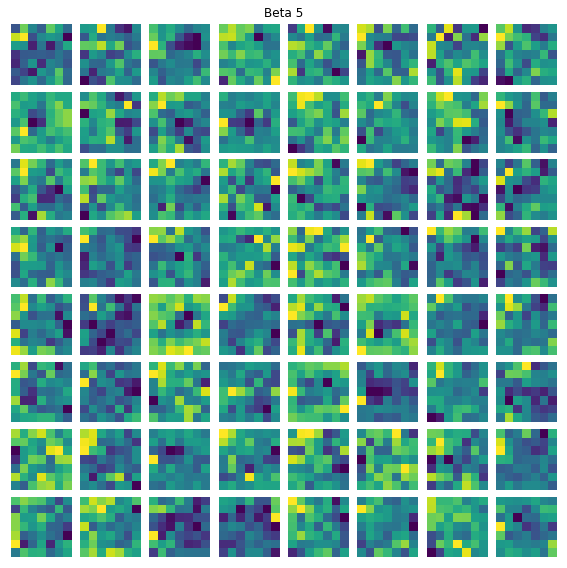

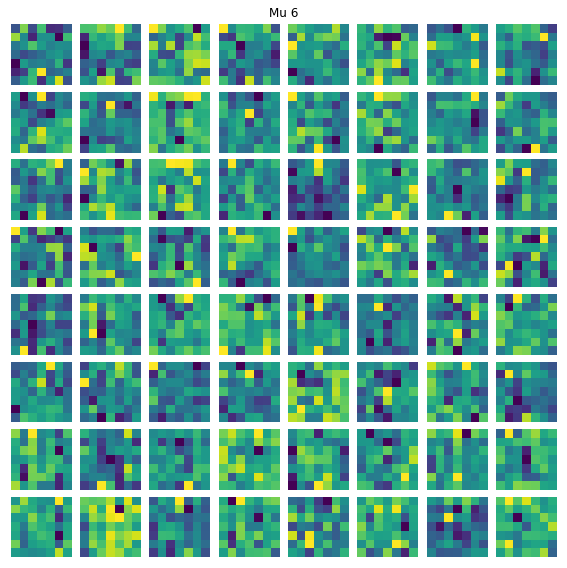

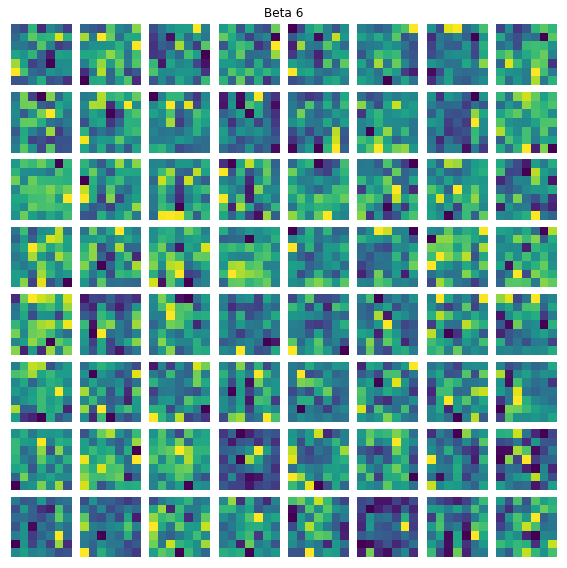

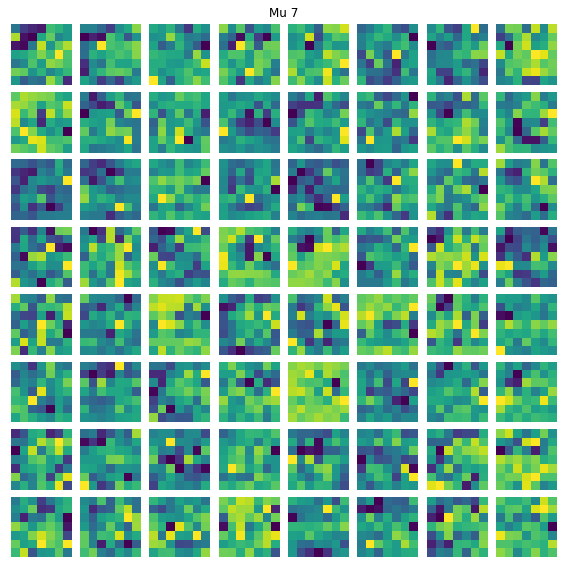

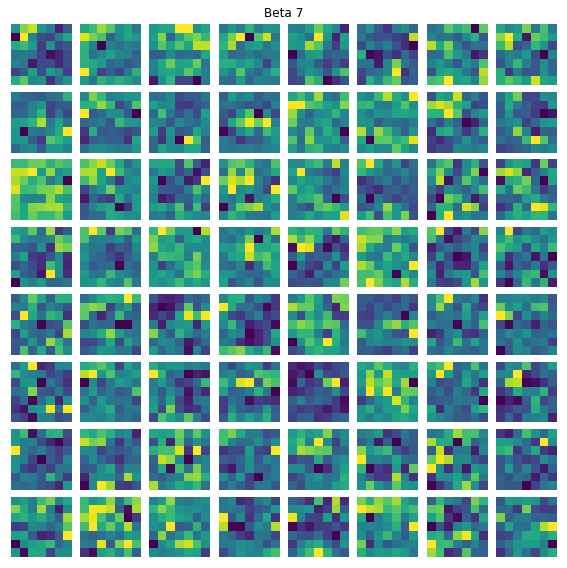

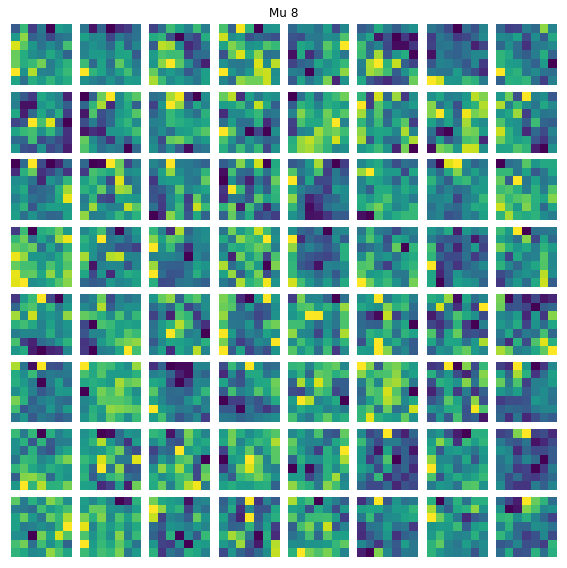

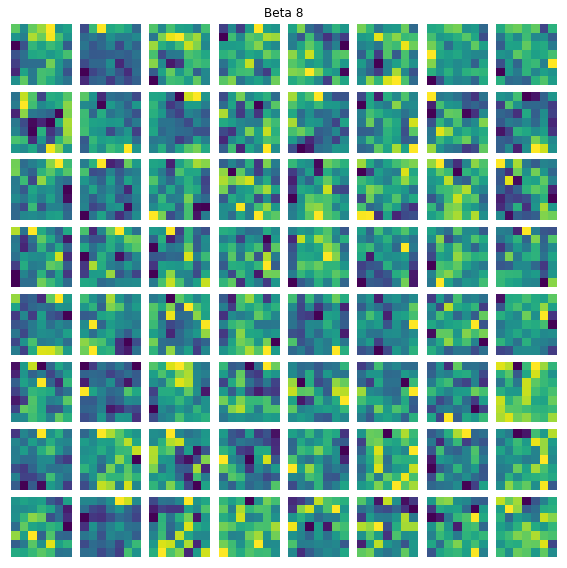

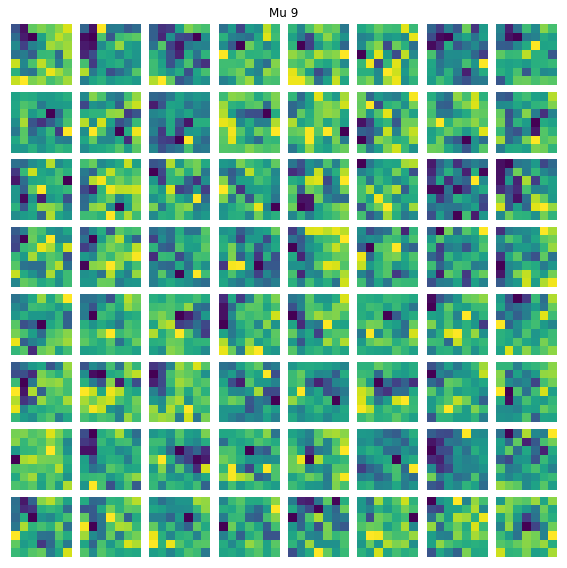

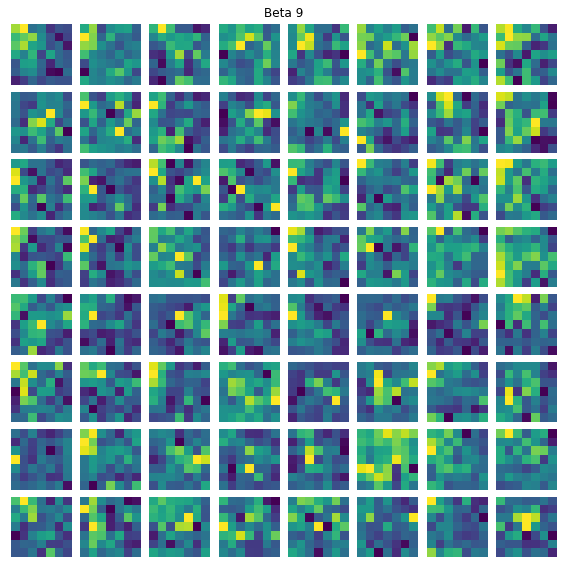

In [19]:
mu, beta = model.layers[-3].get_weights()
mu = mu.reshape(10,7,7,64)
beta = beta.reshape(10,7,7,64)

for i in range(10):
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    axes = axes.flatten()
    for j in range(64):
        axes[j].imshow(mu[i,:,:,j].squeeze())

    plt.suptitle("Mu {}".format(i))
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0, w_pad=0)
    fig.subplots_adjust(top=0.95)

    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    axes = axes.flatten()
    for j in range(64):
        axes[j].imshow(beta[i,:,:,j].squeeze())

    plt.suptitle("Beta {}".format(i))
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0, w_pad=0)
    fig.subplots_adjust(top=0.95)